# Single Character Network

The purpose of this network is to identify which alphanumeric value a CAPTCHA character and takes a centered 32x32 input.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
x = np.load('data/x_single.npy')
y = np.load('data/y_single_pos.npy')

print(f"x shape: {x.shape}")
print(f'y shape: {y.shape}')

x shape: (93600, 32, 32, 3)
y shape: (93600,)


In [7]:
#Converting to greyscale
x = np.mean(x, axis=3)
print(x.shape)

(93600, 32, 32)


In [8]:
#Normalizing
x /= 256
print(f"max x : {np.max(x)}")
print(f"min y : {np.min(x)}")

max x : 0.99609375
min y : 0.0


In [9]:
#Shuffling
print("These should be different")
print(x[0,0,:])
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
x = x[idx, :, :]
y = y[idx]
print(x[0,0,:])
print(x.shape)
print(y.shape)

These should be different
[0.84765625 0.87109375 0.91015625 0.9296875  0.92578125 0.8515625
 0.81640625 0.8046875  0.90625    0.98828125 0.98046875 0.9609375
 0.9296875  0.9296875  0.91796875 0.8515625  0.86328125 0.9609375
 0.9140625  0.85546875 0.91015625 0.94921875 0.9609375  0.96484375
 0.95703125 0.90625    0.875      0.8828125  0.8984375  0.91796875
 0.8515625  0.80859375]
[0.1953125  0.15234375 0.140625   0.140625   0.16015625 0.1640625
 0.1328125  0.1015625  0.1171875  0.12890625 0.12890625 0.12109375
 0.2421875  0.4140625  0.453125   0.359375   0.28515625 0.2734375
 0.26953125 0.33984375 0.41015625 0.5        0.59375    0.640625
 0.66796875 0.734375   0.8515625  0.9296875  0.9140625  0.90234375
 0.921875   0.94140625]
(93600, 32, 32)
(93600,)


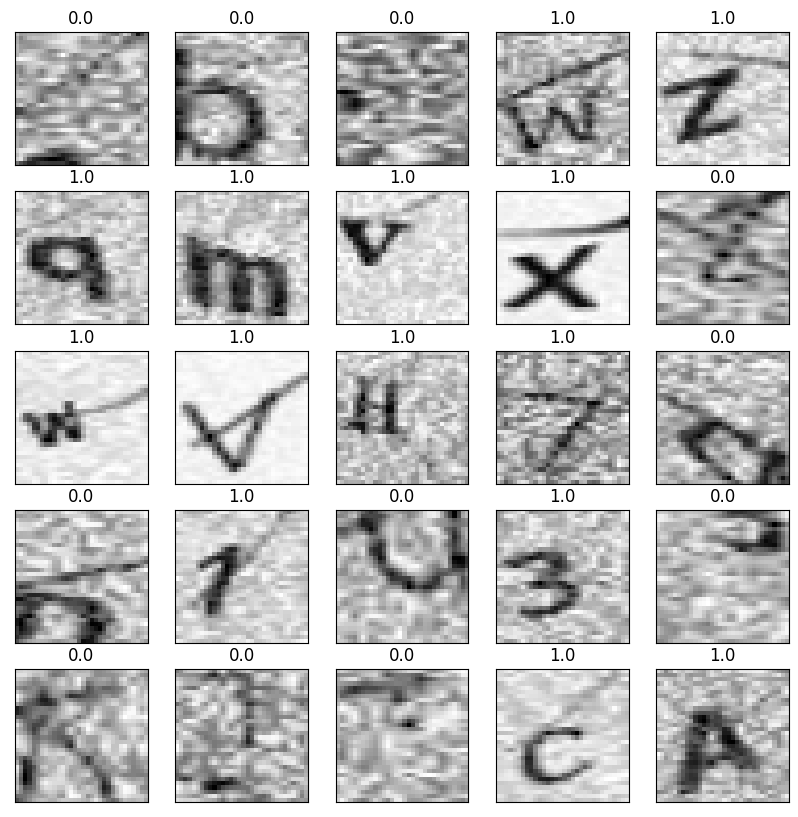

In [10]:
fig, axs = plt.subplots(5,5)
N = x.shape[0]
fig.set_size_inches(10,10)
for i in range(5):
    for j in range(5):
        ax = axs[i,j]
        idx = np.random.randint(N)
        ax.imshow((x[idx,:,:]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(y[idx])
plt.show()

In [11]:
x = np.squeeze(x)
print(x.shape)

(93600, 32, 32)


In [12]:
#We need to have a singlton dim for chans dimention
if(len(x.shape) == 3):
    x = x[:, :, :, None]
print(x.shape)
np.save('data/x_single_preprocessed.npy', x)
np.save('data/y_single_pos_preprocessed.npy', y)
print("Preprocessed data saved to disk")

(93600, 32, 32, 1)
Preprocessed data saved to disk


In [13]:
#Splitting the data in to test and training sets. Going with a 80/20 
#Also getting dev sets for debugging and tuning hyper parameters.

x = np.load('data/x_single_preprocessed.npy')
y = np.load('data/y_single_label_preprocessed.npy')

N = x.shape[0]

split_idx = int(N * 0.8)
test_split = 3000
x_train = x[:split_idx,:, :, :] 
x_val = x[split_idx:-test_split, :, :, :]
x_test = x[-test_split:, :, :, :]
x_train_dev = x[:3000, :, :, :]
x_val_dev = x[split_idx:split_idx+500, :, :, :]

y_train = y[:split_idx] 
y_val = y[split_idx:-test_split]
y_test = y[-test_split:]
y_train_dev = y[:3000]
y_val_dev = y[split_idx:split_idx+500]

dataset = (x_train, x_val, x_test, x_train_dev, x_val_dev, y_train, y_val, y_test, y_train_dev, y_val_dev)

for datum in dataset:
    print(datum.shape)


(74880, 32, 32, 1)
(15720, 32, 32, 1)
(3000, 32, 32, 1)
(3000, 32, 32, 1)
(500, 32, 32, 1)
(74880,)
(15720,)
(3000,)
(3000,)
(500,)


In [17]:
# single character recognition
single = models.Sequential()
#CNN layer
single.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
single.add(layers.MaxPooling2D((2, 2)))
single.add(layers.Conv2D(64, (3, 3), activation='relu'))
single.add(layers.MaxPooling2D((2, 2)))
single.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Dense Layer
single.add(layers.Flatten())
single.add(layers.Dense(64, activation='relu'))
single.add(layers.Dense(32)) 
# change to total alphanumeric  unique values
# change cross entropy to 

single.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [18]:
#Training Network
single.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

single_history = single.fit(x_train_dev, y_train_dev, epochs=10, 
                    validation_data=(x_val_dev, y_val_dev))


Epoch 1/10


2023-04-13 22:18:40.442600: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


94/94 [==============================] - 1s 9ms/step - loss: 0.8929 - accuracy: 0.5060 - val_loss: 0.6835 - val_accuracy: 0.4740
Epoch 2/10
94/94 [==============================] - 1s 8ms/step - loss: 0.5093 - accuracy: 0.7387 - val_loss: 0.3565 - val_accuracy: 0.8460
Epoch 3/10
94/94 [==============================] - 1s 8ms/step - loss: 0.2436 - accuracy: 0.9063 - val_loss: 0.1948 - val_accuracy: 0.9200
Epoch 4/10
94/94 [==============================] - 1s 8ms/step - loss: 0.1640 - accuracy: 0.9353 - val_loss: 0.1548 - val_accuracy: 0.9440
Epoch 5/10
94/94 [==============================] - 1s 8ms/step - loss: 0.1528 - accuracy: 0.9410 - val_loss: 0.1249 - val_accuracy: 0.9580
Epoch 6/10
94/94 [==============================] - 1s 8ms/step - loss: 0.1019 - accuracy: 0.9653 - val_loss: 0.0982 - val_accuracy: 0.9680
Epoch 7/10
94/94 [==============================] - 1s 9ms/step - loss: 0.0712 - accuracy: 0.9760 - val_loss: 0.0976 - val_accuracy: 0.9640
Epoch 8/10
94/94 [=============

94/94 - 0s - loss: 0.0511 - accuracy: 0.9813 - 270ms/epoch - 3ms/step


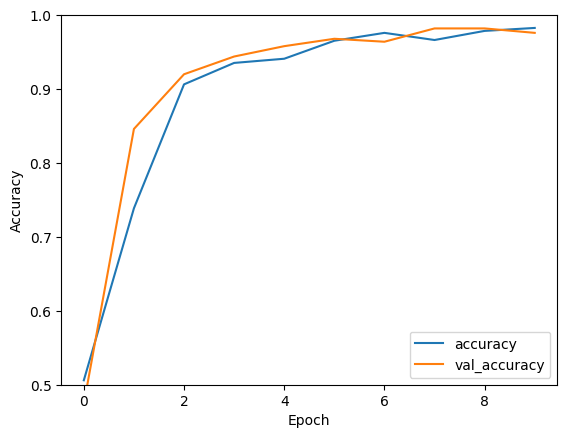

In [19]:
#Plotting Training Data
plt.plot(single_history.history['accuracy'], label='accuracy')
plt.plot(single_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
#Printing the test set accuracy
test_loss, test_acc = single.evaluate(x_test,  y_test, verbose=2)
